## Dataset Generation

### Collecting hold data

In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_image(img,cvt=True):
    if cvt:
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    
# e.g. corners = [(2.0, 1.0), (4.0, 5.0), (7.0, 8.0)]
def polygonal_area(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def read_json(path):
    with open(path) as f:
        json_data = json.load(f)
        hold = json_data["shapes"][0]
        hold_area = polygonal_area(hold["points"])
        
def show_image(img,cvt=True):
    if cvt:
        if len(img.shape) == 2:
            cv2.imshow('img',img)
        else:
            cv2.imshow('img',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
         cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()       
    
        
def resize_image(image, width=750, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)
        


In [3]:

#plot_image(img_src)
#read_json('slab_images/image (1).json')

### Climbing hold dot detection

In [4]:
import rgb_processing

def ratio(n1, n2):
  """Calculates similarity score between 2 numbers
  Args:
      n1 (int): first number
      n2 (int): second number
  Returns:
      (float): similarity score between the 2 numbers
  """
  return 1 - abs(n1 - n2) / (n1 + n2)

def subimage_from_coords(img_src,x1,y1,x2,y2):
    return img_src[y1:y2,x1:x2]

def percentage_dark(img_src,threshold):
    num_dark = np.sum(img_src < threshold)
    num_light =  np.sum(img_src >= threshold)
    return num_dark/(num_light+num_dark)

def find_dots(img_src):
    """Climbing dot detection using connected component analysis
    Args:
        img_src (Mat): the image source
    Returns:
        dot_centres (list): list of (x,y) coordinates of the climbing dots
    """    
    # Create grayscale image
    gray_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

    # Threshold search area
    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 131, 15)
    
    # Blob detection
    _, _, boxes, _ = cv2.connectedComponentsWithStats(binary_img)
    
    # First box is the background
    boxes = boxes[1:]
    
    # For debugging
#     debug_img = img_src.copy()
#     for x,y,w,h,pixels in boxes:
#         cv2.rectangle(debug_img, (x,y), (x+w,y+h), (0,255,0),2) # draw rectangle around the detected dots
#     show_image(resize_image(debug_img,750),cvt=False)
    
    # Threshold blobs by pixel area and percentage of dark pixels
    filtered_boxes = []
    area_thres_lb = 80
    while True:
        for x,y,w,h,pixels in boxes:
            area_limit = (area_thres_lb < pixels < 400)
            subimage = subimage_from_coords(gray_img,x,y,x+w,y+h)

            # Try thresholding by percentage of dark pixels
            p = percentage_dark(subimage,75)
            p_limit = 0.4 < p < 0.6
            if p_limit and area_limit and ratio(w,h) > 0.75:
                filtered_boxes.append((x,y,w,h))   
                
        if len(filtered_boxes) > 15:
            break
        else:
            area_thres_lb -= 20
            filtered_boxes = []
            
        if area_thres_lb < 0:
            raise Exception("No dots can be detected in this image!")
    
#     # Try Kmeans colour thresholding (look for main colour black) if the previous method didn't work
#     if len(filtered_boxes) < 15:
#         filtered_boxes = []
        
#     for x,y,w,h,pixels in boxes:
#         area_limit = (80 < pixels < 400)
#         subimage = subimage_from_coords(gray_img,x,y,x+w,y+h)
        
#         if area_limit and ratio(w,h) > 0.75:
#             colour = rgb_processing.get_main_colour(subimage)
#             if colour == 'black':
#                 filtered_boxes.append((x,y,w,h))


    # Create list of dot centres
    dot_centres = []
    for x,y,w,h in filtered_boxes:
        cv2.rectangle(img_src, (x,y), (x+w,y+h), (0,255,0),2) # draw rectangle around the detected dots
        dot_centre = (round(x+(w/2)),round(y+(h/2)))
        dot_centres.append(dot_centre)
    
    #show_image(resize_image(img_src,300),cvt=False)
    return dot_centres

In [6]:
from scipy import spatial
from statistics import mode
from collections import defaultdict
from math import degrees, atan2, sqrt

def get_direction(c1,c2):
    direction = abs(degrees(atan2(c2[1] - c1[1], c2[0] - c1[0])))
    if 0 < direction < 10 or 85 < direction < 95 or 170 < direction < 180:
        return 'straight'
    elif 40 < direction < 50 or 130 < direction < 140:
        return 'diagonal'
    else:
        return 'other'

def modal_distance(dot_centres):
    """Returns the modal distance between a list of (x,y) coordinates
    Args:
        dot_centres (list): list of (x,y) coordinates of the climbing dots
    Returns:
        avg (int): the modal distance
    """
    modal_distance_map = defaultdict(list)
    direction_count = defaultdict(int)
    distances = []
    for dot_centre in dot_centres:
        # Create list of coordinates that excludes the current iterated coordinate
        other_centres = dot_centres
        other_centres.remove(dot_centre)
        # Kd-tree for quick nearest-neighbor lookup
        tree = spatial.KDTree(other_centres)
        # Append shortest distance to list of distances
        dist, idx = tree.query(dot_centre)
        rounded_dist = round(dist,-1)
        modal_distance_map[rounded_dist].append(dist)
        # Add to direction count dict
        direction = get_direction(dot_centre,other_centres[idx])
        direction_count[direction] += 1
    
    modal_distance = max(modal_distance_map, key=lambda key: len(modal_distance_map[key]))
    dists = modal_distance_map[modal_distance]
    
    mean_dist = np.mean(dists)
    #print(direction_count)
    if direction_count['diagonal'] > direction_count['straight']:
        dist = sqrt(mean_dist**2/2)*2
    else:
        dist = mean_dist
        
    scale = 15/dist
    
    if scale > 0.5:
        raise Exception(f"The scale value {scale} is too large, the dot detection is likely to be broken. ")
    else:
        return dist

img_src = cv2.imread('route_images/black_V2-V4 (4).jpg')
dot_centres = find_dots(img_src)
dist = modal_distance(dot_centres)
cv2.line(img_src, (400,400), (400,400+round(dist)), (255,0,0), 5)
show_image(resize_image(img_src))
print(f"cm/pixel: {15/dist}")
    

cm/pixel: 0.07579687351217687


### Route detection

9


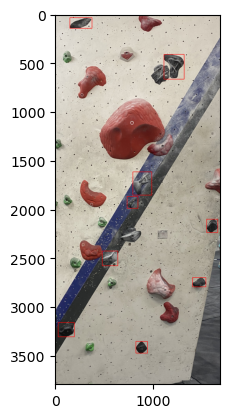

In [7]:
import rgb_processing
import pickle

classes = np.array(['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','curve_edge_sloper','edge','pocket','pinch','edge_sloper','volume','large_moon_edge','platform','u_edge'])

def cut_from_contour(img, contour):
    mask = np.zeros(img.shape, np.uint8) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contour, -1, (255,255,255), -1)
    extracted_hold = np.zeros(img.shape, np.uint8) # Extract out the object and place into output image
    extracted_hold[mask > 0] = img[mask > 0]   
    return extracted_hold

def load_data_from_pickle(file_name):
    with open(f'tensor_data/{file_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data
def filter_route(file_name,colour="",scale=1):

    # Load hold data from the file
    data = load_data_from_pickle(file_name)
    
    # Load image file
    img = cv2.imread(f'route_images/{file_name}.jpg')
    
    # Retrieve required colour
    if not colour:
        expected_colour = file_name.split("_")[0]
    else:
        expected_colour = colour

    # For debugging
    img_detections = img.copy()
    #print(len(data["contours"]))
    
    # Retrieve indices of all holds that are relevant to the route by its colour
    route_indices = []
    for idx, bb in enumerate(data['pred_boxes']):
        
        contour = data['contours'][idx]
        r_bb = np.round(bb).astype('int')
        
        # For debugging
        cv2.rectangle(img_detections, (r_bb[0],r_bb[1]), (r_bb[2],r_bb[3]), (0,0,255),4)
       
        # Cut out hold
        extracted_hold = cut_from_contour(img,contour)
        
        # Retrieve colour of hold
        hold_img = subimage_from_coords(extracted_hold,r_bb[0],r_bb[1],r_bb[2],r_bb[3])
        hold_colour = rgb_processing.get_main_colour(hold_img)
        #print(hold_colour)
        
        if expected_colour in hold_colour:
            route_indices.append(idx)
    
    if not route_indices:
        raise Exception(f'Unable to detect any holds')
    
    # Filter out overlapping bounding boxes using non maximal suppression
    boxes = [data['pred_boxes'][i] for i in route_indices]
    confidences = [float(data['scores'][i]) for i in route_indices]
    NMS_indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.7)
    route_indices = [route_indices[i] for i in NMS_indices]
    
    # Scale the contour areas of the relevant holds
    for i in route_indices:
        data['contour_area'][i] *= scale
    
    #route_indices = [i for i in route_indices if data['contour_area'][i] > 1]
        
    # For debugging
    #show_image(resize_image(img_detections,300),cvt=False)
    return data, route_indices

file_name = "black_V2-V4 (4)"
img = cv2.imread(f'route_images/{file_name}.jpg')
data, hold_ids = filter_route(file_name)
print(len(hold_ids))
for i in hold_ids:
    r_bb = np.round(data['pred_boxes'][i]).astype('int')
    cv2.rectangle(img, (r_bb[0],r_bb[1]), (r_bb[2],r_bb[3]), (0,0,255),4)
plot_image(img)

### Route sequencing (distance between holds and direction between holds)

In [8]:
from math import hypot, atan2, degrees

def centres_from_boxes(bounding_boxes):
    centres = [((bb[0]+bb[2])/2,(bb[1]+bb[3])/2) for bb in bounding_boxes]
    return np.round(centres).astype('int')

def get_route(hold_ids,hold_centres):
    z = zip(hold_ids,hold_centres)
    zs = sorted(z, key = lambda x: x[1][1],reverse=True)
    sorted_ids, sorted_centres = map(list, zip(*zs))
    return sorted_ids, sorted_centres

def get_distance_direction(route,route_centres,scale):
    distance_map = dict()   
    direction_map = dict()
    
    for i, hold_id in enumerate(route):
        c1 = route_centres[i]
        if i < len(route)-1:
            c2 = route_centres[i+1]
            distance_map[hold_id] = hypot(c2[0] - c1[0], c2[1] - c1[1]) * scale
            direction_map[hold_id] = abs(degrees(atan2(c2[1] - c1[1], c2[0] - c1[0])))
        else:
            distance_map[hold_id] = 0
            direction_map[hold_id] = 0
            
    return distance_map, direction_map
        
        
file_name = "green_VB (32)"
img = cv2.imread(f'route_images/{file_name}.jpg')

# Find dot centres to scale distances
dot_centres = find_dots(img)
dot_dist = modal_distance(dot_centres)
scale = 15/dot_dist
print(f"Scale: {scale}")

# Retrieve only the holds that are relevant to the route
data, hold_ids = filter_route(file_name,scale=scale)

print(hold_ids)

# Create centre coordinates for each hold
bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
hold_centres = centres_from_boxes(bounding_boxes)

# Create mapping from hold id to its centre
id_to_centre = dict()
for i,hold_id in enumerate(hold_ids):
    id_to_centre[hold_id] = hold_centres[i]
    
# Create a route as a sequence of holds sorted by y
route, route_centres = get_route(hold_ids,hold_centres)
print(f"Route: {route}")

# Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
distance_map, direction_map = get_distance_direction(route,route_centres,scale)

print(distance_map)
print(direction_map)

# Show the route
temp = img.copy()
for i,hold_id in enumerate(route):
    text = f"{str(i)} ({hold_id})"
    coords = id_to_centre[hold_id]
    coords[0] -= 75
    bb = np.round(data['pred_boxes'][hold_id]).astype('int')
    cv2.putText(temp, text, coords, cv2.FONT_HERSHEY_TRIPLEX , 1.25, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.rectangle(temp, (bb[0],bb[1]), (bb[2],bb[3]), (0, 0, 255), 2)

show_image(resize_image(temp,300),cvt=False)



Scale: 0.09424374340134681
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Route: [9, 7, 16, 17, 13, 1, 12, 4, 6, 5, 15, 10, 14, 3, 8, 11, 2, 0]
{9: 47.386893790529975, 7: 50.04413767511645, 16: 44.08683635515276, 17: 51.58233088416295, 13: 58.24004089889915, 1: 39.27986065460649, 12: 47.21874892833314, 4: 98.29640508410859, 6: 46.52434769668289, 5: 32.74614107265444, 15: 44.09680766495324, 10: 67.47957326986796, 14: 20.730410444439162, 3: 38.273868255996774, 8: 54.86718252265892, 11: 41.774967777761475, 2: 41.72731538420265, 0: 0}
{9: 161.92539724046523, 7: 29.316609678649638, 16: 63.05152198789604, 17: 151.2809307916719, 13: 17.613980535398227, 1: 161.39116467145112, 12: 173.69769393041545, 4: 12.570516359915553, 6: 173.0189425931702, 5: 112.50570481227874, 15: 141.0724564072077, 10: 0.3200848237816687, 14: 133.71060209593975, 3: 58.69750547491191, 8: 169.80958649225565, 11: 37.85231021361413, 2: 133.71883830535793, 0: 0}


### Preparing the dataset

In [9]:
import glob
import os
import random

def check_num_samples(path):
    class_count = defaultdict(int)
    for file_path in glob.glob(path):
        for cls in ['VB','V0-V2','V1-V3','V2-V4','V3-V5']:
            if cls in file_path:
                class_count[cls] += 1
    print(class_count)
    
def get_route_images(path, classes, num_per_cls=16):
    
    route_files_by_class = defaultdict(list)
    for file_path in glob.glob(path):
        for cls in classes:
            if cls in file_path:
                file_name = os.path.basename(file_path)
                route_files_by_class[cls].append(file_name)

                
    for cls in classes:
        random.shuffle(route_files_by_class[cls])
        route_files_by_class[cls] = route_files_by_class[cls][0:num_per_cls]
        if len(route_files_by_class[cls]) != num_per_cls:
            raise Exception(f"The class {cls} does not have {num_per_cls} images in the dataset.")
    
    return route_files_by_class

def approximate_area_from_bb(bb):
    x_len = bb[2]-bb[0]
    y_len = bb[3]-bb[1]
    return 0.5 * (x_len*y_len)

# For debugging purposes
def generate_datum(file_name):
    print(f'Processing {file_name}')

    # Find dot centres to define scale
    img = cv2.imread(f'route_images/{file_name}')
    scale = 15/modal_distance(find_dots(img))

    # Retrieve only the holds that are relevant to the route
    data, hold_ids = filter_route(os.path.basename(file_name).split(".")[0],scale=scale)

    # Create centre coordinates for each hold
    bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
    hold_centres = centres_from_boxes(bounding_boxes)

    # Create mapping from hold id to its centre
    id_to_centre = dict()
    for i,hold_id in enumerate(hold_ids):
        id_to_centre[hold_id] = hold_centres[i]

    # Create a route as a sequence of holds sorted by y
    route, route_centres = get_route(hold_ids,hold_centres)

    # Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
    distance_map, direction_map = get_distance_direction(route,route_centres,scale)

    # Create feature data
    feature_data = []
    for hold_id in route:
        cls = data['pred_classes'][hold_id]
        contour_area = data['contour_area'][hold_id]
        area = data['contour_area'][hold_id] * scale
        distance_to_next_hold = distance_map[hold_id]
        direction_to_next_hold = direction_map[hold_id]
        feature_data.append([cls,area,distance_to_next_hold,direction_to_next_hold])    
        
    return(feature_data)
    
def generate_dataset(route_images_by_class):
    dataset = []
    for cls in classes:
        for file_name in route_images_by_class[cls]:
            print(f'Processing {file_name}')
            
            # Find dot centres to define scale
            img = cv2.imread(f'route_images/{file_name}')
            scale = 15/modal_distance(find_dots(img))
            
            # Retrieve only the holds that are relevant to the route
            data, hold_ids = filter_route(os.path.basename(file_name).split(".")[0],scale=scale)

            # Create centre coordinates for each hold
            bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
            hold_centres = centres_from_boxes(bounding_boxes)

            # Create mapping from hold id to its centre
            id_to_centre = dict()
            for i,hold_id in enumerate(hold_ids):
                id_to_centre[hold_id] = hold_centres[i]

            # Create a route as a sequence of holds sorted by y
            route, route_centres = get_route(hold_ids,hold_centres)

            # Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
            distance_map, direction_map = get_distance_direction(route,route_centres,scale)
            
            # Create feature data
            feature_data = []
            for hold_id in route:
                cls = data['pred_classes'][hold_id]
                contour_area = data['contour_area'][hold_id]
                
                # There is a bug where OpenCV can't calculate the contour area and for some binary masks
                # So approximate it from the bounding box
                if contour_area < 1:
                    area = approximate_area_from_bb(data['pred_boxes'][hold_id]) * scale
                else:
                    area = contour_area * scale
                
                distance_to_next_hold = distance_map[hold_id]
                direction_to_next_hold = direction_map[hold_id]
                feature_data.append([cls,area,distance_to_next_hold,direction_to_next_hold])
            
            dataset.append((file_name,feature_data))
    
    print('Finished!')
    return dataset

# datum = generate_datum("black_V2-V4 (4).jpg")
# print(datum)
# print(len(datum))

# ROUTE_IMAGES_PATH = ('route_images/*')

# classes = ['VB','V1-V3','V2-V4','V3-V5']
# check_num_samples(ROUTE_IMAGES_PATH)
# route_images_by_class = get_route_images(ROUTE_IMAGES_PATH, classes, num_per_cls=15)
# dataset = generate_dataset(route_images_by_class)

In [ ]:
# Optionally cache the dataset
cache = True
if cache:
    with open('dataset.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Normalising the dataset

In [10]:
def normalise_value(v,min_v,max_v):
    return (v - min_v) / (max_v - min_v)

def normalise_hold(hold_type,num_classes):
    return hold_type/num_classes

def cls_from_route_label(name):
    classes = ['VB','V1-V3','V2-V4','V3-V5']
    for i,cls in enumerate(classes):
        if cls in name:
            return i
    
def normalise_dataset(dataset,num_classes):
    
    cls_labels = [cls_from_route_label(file_name) for file_name,_ in dataset]
    dataset_without_files = [data for _,data in dataset]
    
    contour_areas = []
    distances = []
    directions = []
    hold_counts = []
    
    # Create lists of all contour areas, distances and directions
    for i,route_data in enumerate(dataset_without_files):
        hold_count = 0
        for hold in route_data:
            contour_areas.append(hold[1])
            distances.append(hold[2])
            directions.append(hold[3])
            hold_count +=1
        hold_counts.append(hold_count)
    
    min_area = np.amin(contour_areas)
    max_area = np.amax(contour_areas)
    min_dist = np.amin(distances)
    max_dist = np.amax(distances)
    max_holds = np.amax(hold_counts)
    
    # Normalise the data
    for i, route_data in enumerate(dataset_without_files):
        for j, hold in enumerate(route_data):   
            norm_hold = normalise_hold(hold[0],num_classes)
            norm_area = normalise_value(hold[1],min_area,max_area)
            norm_dist = normalise_value(hold[2],min_dist,max_dist)
            norm_dir = normalise_value(hold[3],0,180)
            normalised_data = [norm_hold,norm_area,norm_dist,norm_dir]
            dataset_without_files[i][j] = normalised_data
    
    # Pad any routes until they reach the maximum hold count
    for i in range(len(dataset_without_files)):
        num_holds = len(dataset_without_files[i])
        diff = abs(max_holds-num_holds)
        if diff > 0:
            for d in range(diff):
                dataset_without_files[i].append([0,0,0,0])
    
    normalised_dataset = list(zip(dataset_without_files,cls_labels))
    normalisation_values = [min_area,max_area,min_dist,max_dist,max_holds,num_classes]
    return normalised_dataset, normalisation_values

# Debugging purposes
#     print(f'Minimum area: {np.amin(contour_areas)}')
#     print(f'Minimum distance: {np.amin(distances)}')
#     print(f'Minimum direction: {np.amin(directions)}')
#     print(f'Maximum area: {np.amax(contour_areas)}')
#     print(f'Maximum distance: {np.amax(distances)}')
#     print(f'Maximum direction: {np.amax(directions)}')
    
    

# Load dataset from cache
with open('dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

hold_classes = ['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','curve_edge_sloper','edge','pocket','pinch','edge_sloper','volume','large_moon_edge','platform','u_edge']
normalised_dataset, norm_values = normalise_dataset(dataset,len(hold_classes))


In [11]:
# normalised_dataset[i] returns ([data],label) for the sample at i
X = np.array([data for data,_ in normalised_dataset])
y = np.array([label for _,label in normalised_dataset])



print(X.shape)
print(y.shape)

(60, 18, 4)
(60,)


### Build Keras Model

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()

model.add(LSTM(32, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))



      




### Train Model

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'],
)

model.summary()

model.fit(X_train,
          y_train,
          epochs=50,
          validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 32)            4736      
                                                                 
 dropout (Dropout)           (None, 18, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

Epoch 50/50
2/2 [==============================] - 0s 36ms/step - loss: 0.8097 - accuracy: 0.6875 - val_loss: 6.0056 - val_accuracy: 0.4167


In [87]:

route_classes = ['VB','V1-V3','V2-V4','V3-V5']

# Single sample prediction
sample_num = 47
sample = X_train[sample_num:sample_num+1]
print(sample)
prediction = model.predict(sample)
print(prediction)

expected_class = route_classes[y_train[sample_num]]
class_prediction = route_classes[np.argmax(prediction)]
print(f'Predicted: {class_prediction}, Actual: {expected_class}')

# Accuracy on test set
num_correct = 0
num_total = X_test.shape[0]
for i in range(num_total):
    sample = X_test[i:i+1]
    prediction = model.predict(sample)
    class_prediction = np.argmax(prediction)
    expected_class = y_test[i]
    if class_prediction == expected_class:
        num_correct += 1
print(f'Test Accuracy: {(num_correct/num_total)*100}%')

# Accuracy on train set
num_correct = 0
num_total = X_train.shape[0]
for i in range(num_total):
    sample = X_train[i:i+1]
    prediction = model.predict(sample)
    class_prediction = np.argmax(prediction)
    expected_class = y_train[i]
    if class_prediction == expected_class:
        num_correct += 1
print(f'Train Accuracy: {(num_correct/num_total)*100}%')


[[[0.57142857 0.01308474 0.3819312  0.9409798 ]
  [0.0952381  0.04817639 0.19829261 0.62150524]
  [0.57142857 0.00983895 0.13837173 0.58858553]
  [0.14285714 0.32795831 0.44052154 0.94953545]
  [0.57142857 0.00986521 0.94428854 0.0192327 ]
  [0.14285714 0.36957789 1.         0.96763143]
  [0.57142857 0.00985511 0.49983623 0.10041555]
  [0.14285714 0.67577449 0.18424655 0.78277569]
  [0.14285714 0.6483479  0.30274661 0.88680975]
  [0.14285714 0.30930564 0.12657992 0.08351211]
  [0.42857143 0.01606997 0.16068298 0.61730513]
  [0.14285714 0.28245267 0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]]
1/1 [==============================] - 0s 20ms/step
[[1.9597474e-17 4.4469527e-08 5.7488523e-07 9.9999940e-01]]
Predicted: V3-V5, Actu

### Prediction from image input

In [57]:
# For debugging purposes
def generate_datum_norm(file_name,norm_values,num_classes):
    min_area = norm_values[0]
    max_area = norm_values[1]
    min_dist = norm_values[2]
    max_dist = norm_values[3]
    max_holds = norm_values[4]
    
    print(f'Processing {file_name}')

    # Find dot centres to define scale
    img = cv2.imread(f'route_images/{file_name}')
    scale = 15/modal_distance(find_dots(img))

    # Retrieve only the holds that are relevant to the route
    data, hold_ids = filter_route(os.path.basename(file_name).split(".")[0],scale=scale)

    # Create centre coordinates for each hold
    bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
    hold_centres = centres_from_boxes(bounding_boxes)

    # Create mapping from hold id to its centre
    id_to_centre = dict()
    for i,hold_id in enumerate(hold_ids):
        id_to_centre[hold_id] = hold_centres[i]

    # Create a route as a sequence of holds sorted by y
    route, route_centres = get_route(hold_ids,hold_centres)

    # Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
    distance_map, direction_map = get_distance_direction(route,route_centres,scale)

    # Create normalised feature data
    feature_data = []
    for hold_id in route:
        cls = data['pred_classes'][hold_id] / num_classes
        contour_area = normalise_value(data['contour_area'][hold_id]*scale,min_area,max_area)
        distance_to_next_hold = normalise_value(distance_map[hold_id]*scale,min_dist,max_dist)
        direction_to_next_hold = normalise_value(direction_map[hold_id]*scale,0,180)
        feature_data.append([cls,contour_area,distance_to_next_hold,direction_to_next_hold])
    
    # Pad route until it reaches the maximum hold count
    num_holds = len(feature_data)
    diff = abs(max_holds-num_holds)
    if diff > 0:
        for d in range(diff):
            feature_data.append([0,0,0,0]) 
            
    return feature_data, cls_from_route_label(file_name)

def predict_from_image(model,file_name,norm_values,num_classes):
    X, y = generate_datum_norm(file_name,norm_values,num_classes)
    X = np.array(X)
    X = X[None, :, :]
    print(X.shape)
    
    route_classes = ['VB','V1-V3','V2-V4','V3-V5']
    
    prediction = model.predict(X)
    expected_class = route_classes[y]
    class_prediction = route_classes[np.argmax(prediction)]
    print(f'Predicted: {class_prediction}, Actual: {expected_class}')
    

file_name = "blue_VB.jpg"
predict_from_image(model,file_name,norm_values,22)



Processing blue_VB.jpg
(1, 18, 4)
1/1 [==============================] - 0s 18ms/step
Predicted: V3-V5, Actual: VB
